In [2]:
## fluorescence spectroscopy in ice and water (2.46 M solution)

In [3]:
%matplotlib ipympl

import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from onix.data_tools import get_experiment_data
from onix.helpers import data_identifier, console_bold, present_float
from onix.units import ureg, Q_
from onix.analysis.fitter import Fitter

import pickle

In [4]:
def exp_decay(t, tau, a, c):
    return np.exp(-t / tau) * a + c

In [5]:
class FluorescenceDecay:
    def __init__(self, data_signal):
        self._data_signal = data_signal
        self._excitation_time = self._data_signal[1]["excitation_time"].to("s").magnitude
        if "frequency" in self._data_signal[1]:
            self.freq = self._data_signal[1]["frequency"]
        else:
            self.freq = None
        try:
            self.normalizer = self._data_signal[1]["normalizer"]
        except KeyError:
            self.normalizer = None
        self._excitation_delay = self._data_signal[1]["excitation_delay"].to("s").magnitude
        self._test_time = self._data_signal[1]["test_time"].to("s").magnitude
        self._average_data()
        
    def _average_data(self):
        self._times = self._data_signal[0]["pmt_times"]
        self.times_ms = self._times * 1e3
        signal_voltages = self._data_signal[0]["pmt_voltages"]
        self.V_signal_avg = np.average(signal_voltages, axis=0)
        self.V_signal_err = np.std(signal_voltages, axis=0) / np.sqrt(len(signal_voltages))
    
    def get_test_data(self, offset_time=100e-6):
        test_start_time = offset_time * 2
        test_end_time = offset_time * 2 + self._test_time + self._excitation_delay * 2
        test_mask = np.bitwise_and(
            self._times > test_start_time,
            self._times <= test_end_time,
        )
        self._test_end = test_end_time + offset_time
        self.test_times_ms = self.times_ms[test_mask]
        self.V_signal_test_avg = self.V_signal_avg[test_mask]
        self.V_signal_test_err = self.V_signal_err[test_mask]

    def get_decay_data(self):
        decay_start_time = self._test_end + self._excitation_delay * 2 + self._excitation_time
        decay_mask = self._times > decay_start_time
        decay_start_time_ms = decay_start_time * 1e3
        self.decay_times_ms = self.times_ms[decay_mask] - decay_start_time_ms
        self.V_signal_decay_avg = self.V_signal_avg[decay_mask]
        self.V_signal_decay_err = self.V_signal_err[decay_mask]

In [13]:
def data_from_dnum(data_number: int, default_excitation_time_ms = 5, default_excitation_delay_us = 10, default_test_time_us = 500):
    raw_data = get_experiment_data(data_number)
    if "excitation_time" not in raw_data[1]:
        raw_data[1]["excitation_time"] = default_excitation_time_ms * ureg.ms
        print(f"excitation_time in data #{data_number} is set to {raw_data[1]['excitation_time']}.")
    if "excitation_delay" not in raw_data[1]:
        raw_data[1]["excitation_delay"] = default_excitation_delay_us * ureg.us
        print(f"excitation_delay in data #{data_number} is set to {raw_data[1]['excitation_delay']}.")
    if "test_time" not in raw_data[1]:
        raw_data[1]["test_time"] = default_test_time_us * ureg.us
        print(f"test_time in data #{data_number} is set to {raw_data[1]['test_time']}.")
    data = FluorescenceDecay(raw_data)
    identifier = "data " + data_identifier([data_number])
    return data, identifier

def plot_three_panel(data, identifier):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw={"width_ratios": [2, 2, 4], "height_ratios": [3, 1]})
    axs[0][0].errorbar(data.times_ms, data.V_signal_avg, data.V_signal_err, label="signal")
    axs[0][0].set_xlabel("time (ms)")
    axs[0][0].set_ylabel("PMT voltage (V)")
    axs[0][0].legend()

    data.get_test_data()
    axs[0][1].errorbar(data.test_times_ms, data.V_signal_test_avg, data.V_signal_test_err, label="signal test")
    axs[0][1].set_xlabel("time (ms)")
    axs[0][1].set_ylabel("PMT voltage (V)")
    axs[0][1].legend()

    data.get_decay_data()
    fitter = Fitter(exp_decay)
    fitter.set_data(data.decay_times_ms, data.V_signal_decay_avg, data.V_signal_decay_err)
    fitter.set_p0({"tau": 0.1, "a": 10, "c": 0})
    fitter.fit()
    
    axs[0][2].errorbar(data.decay_times_ms, data.V_signal_decay_avg, data.V_signal_decay_err, label="data")
    axs[0][2].plot(data.decay_times_ms, fitter.fitted_value(data.decay_times_ms), label="fit", zorder=50)
    axs[0][2].text(0.2, 0.5, fitter.all_results_str(), transform=axs[0][2].transAxes)
    axs[0][2].legend()
    axs[0][2].set_ylabel("PMT voltage (V)")
    
    axs[1][2].scatter(data.decay_times_ms, fitter.studentized_residuals(), s=5)
    axs[1][2].set_xlim(*axs[0][2].get_xlim())
    axs[1][2].use_sticky_edges = True
    axs[1][2].hlines([-3, -2, -1, 0, 1, 2, 3], *axs[0][2].get_xlim(), zorder=0, color="grey", linewidth=0.5)
    axs[1][2].use_sticky_edges = False
    
    axs[1][2].set_xlabel("time (ms)")
    axs[1][2].set_ylabel("Studentized residuals")

    plt.tight_layout()
    plt.show()

In [42]:
data_numbers = list(range(246116, 246151))
all_data = {}
try:
    with open("all_ice_fluorescence_spectroscopy_data.pickle", "rb") as f:
        all_data = pickle.load(f)
except Exception as e:
    print("load all data from vault")
    for kk in data_numbers:
        all_data[kk] = data_from_dnum(kk)
for kk in all_data:
    print(kk)
    #plot_three_panel(*all_data[kk])

246116
246117
246118
246119
246120
246121
246122
246123
246124
246125
246126
246127
246128
246129
246130
246131
246132
246133
246134
246135
246136
246137
246138
246139
246140
246141
246142
246143
246144
246145
246146
246147
246148
246149
246150


In [19]:
# with open("all_ice_fluorescence_spectroscopy_data.pickle", "wb") as f:
#     pickle.dump(all_data, f)

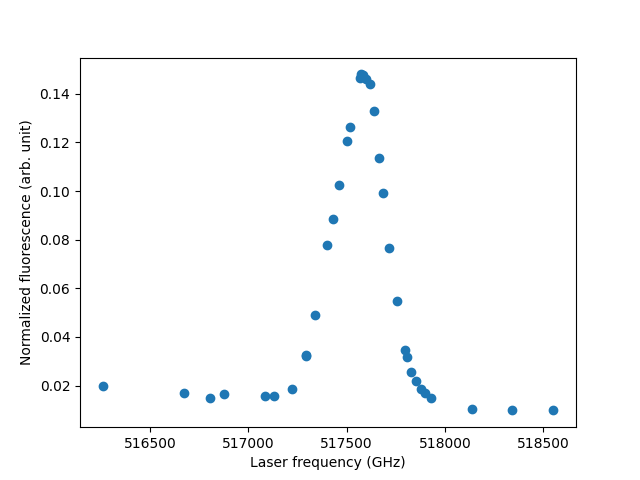

In [37]:
freqs_ice = []
normalizers_ice = []
fluorescences_ice = []
for kk in all_data:
    freqs_ice.append(all_data[kk][0].freq)
    normalizers_ice.append(np.average(all_data[kk][0].V_signal_test_avg))
    fitter = Fitter(exp_decay)
    fitter.set_data(all_data[kk][0].decay_times_ms, all_data[kk][0].V_signal_decay_avg, all_data[kk][0].V_signal_decay_err)
    fitter.set_p0({"tau": 0.1, "a": 10, "c": 0})
    fitter.fit()
    fluorescences_ice.append(fitter.results["a"])

normalized_fluorescence_ice = np.array(fluorescences_ice) / np.array(normalizers_ice)
fig, ax = plt.subplots()
ax.scatter(freqs_ice, normalized_fluorescence_ice)
ax.set_xlabel("Laser frequency (GHz)")
ax.set_ylabel("Normalized fluorescence (arb. unit)")
plt.show()

In [39]:
data_numbers = list(range(246153, 246244))
all_data = {}
try:
    with open("all_water_fluorescence_spectroscopy_data.pickle", "rb") as f:
        all_data = pickle.load(f)
except Exception as e:
    print("load all data from vault")
    for kk in data_numbers:
        all_data[kk] = data_from_dnum(kk)
for kk in all_data:
    print(kk)
    #plot_three_panel(*all_data[kk])

246153
246154
246155
246156
246157
246158
246159
246160
246161
246162
246163
246164
246165
246166
246167
246168
246169
246170
246171
246172
246173
246174
246175
246176
246177
246178
246179
246180
246181
246182
246183
246184
246185
246186
246187
246188
246189
246190
246191
246192
246193
246194
246195
246196
246197
246198
246199
246200
246201
246202
246203
246204
246205
246206
246207
246208
246209
246210
246211
246212
246213
246214
246215
246216
246217
246218
246219
246220
246221
246222
246223
246224
246225
246226
246227
246228
246229
246230
246231
246232
246233
246234
246235
246236
246237
246238
246239
246240
246241
246242
246243


In [33]:
# with open("all_water_fluorescence_spectroscopy_data.pickle", "wb") as f:
#     pickle.dump(all_data, f)

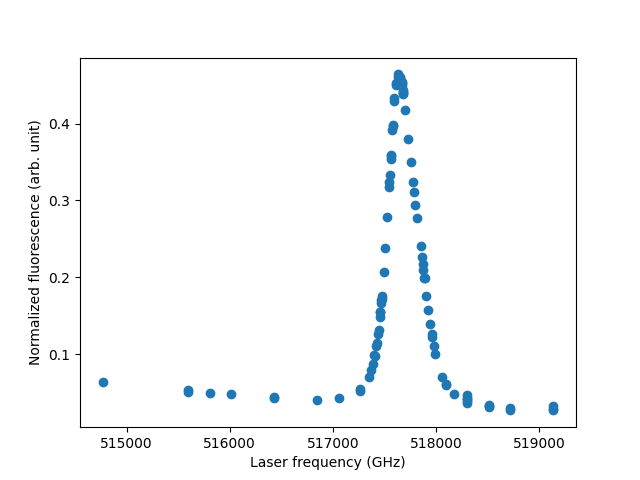

In [40]:
freqs_water = []
normalizers_water = []
fluorescences_water = []
for kk in all_data:
    freqs_water.append(all_data[kk][0].freq)
    normalizers_water.append(np.average(all_data[kk][0].V_signal_test_avg))
    fitter = Fitter(exp_decay)
    fitter.set_data(all_data[kk][0].decay_times_ms, all_data[kk][0].V_signal_decay_avg, all_data[kk][0].V_signal_decay_err)
    fitter.set_p0({"tau": 0.1, "a": 10, "c": 0})
    fitter.fit()
    fluorescences_water.append(fitter.results["a"])

normalized_fluorescence_water = np.array(fluorescences_water) / np.array(normalizers_water)
fig, ax = plt.subplots()
ax.scatter(freqs_water, normalized_fluorescence_water)
ax.set_xlabel("Laser frequency (GHz)")
ax.set_ylabel("Normalized fluorescence (arb. unit)")
plt.show()

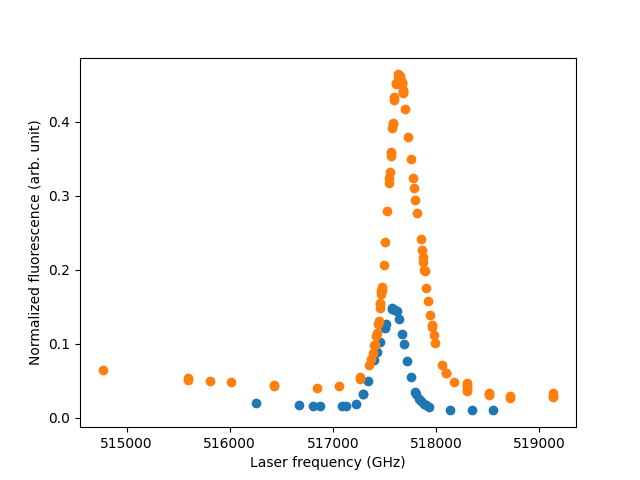

In [41]:
fig, ax = plt.subplots()
ax.scatter(freqs_ice, normalized_fluorescence_ice)
ax.scatter(freqs_water, normalized_fluorescence_water)
ax.set_xlabel("Laser frequency (GHz)")
ax.set_ylabel("Normalized fluorescence (arb. unit)")
plt.show()